# Import packages

In [1]:
import pandas as pd
import numpy as np

import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import sklearn
from funct import dfOverView_toDf

from sklearn.metrics import mean_squared_error as mse
from math import sqrt

# Import & process data

In [2]:
consumption_fraction = 0.5
# If this is == True, then all consumption turns only baseload with fraction consumption_fraction
baseload_calc = False
# If this is != None, then all consumption and baseload is calculated based on annual output
MWh_annual_vol = None
level = 2

In [3]:
data_RfP = pd.read_excel('RfP_Evaluation.xlsx', sheet_name = 'RfP - Evaluation')

In [4]:
def load_data(data_RfP, level, consumption_fraction, baseload_calc, MWh_annual_vol):
    
    if level == 1:

        data_iceland = pd.read_excel('HH Analysis Iceland.xlsx', sheet_name = 'Iceland HH _Residual')
        customer_consumption = data_iceland.iloc[1,2:-1].values

        if MWh_annual_vol == None:

            baseload_list = customer_consumption.min() 
            baseload = np.array(np.array([baseload_list]*len(customer_consumption)))*consumption_fraction

            if baseload_calc == True:
                customer_consumption = baseload.copy()
            else:
                customer_consumption = customer_consumption*consumption_fraction

        else:
            baseload = np.array(np.array([MWh_annual_vol/365/48]*len(customer_consumption)))
            customer_consumption = baseload.copy()

    if level == 2:

        data_iceland = pd.read_csv("Iceland Aggregated.csv", index_col=0, header = None)

        if MWh_annual_vol == None:

            data_iceland.index = pd.to_datetime(data_iceland.index, format='%d/%m/%Y %H:%M')
            customer_consumption = data_iceland.resample('D').sum()
            customer_consumption =customer_consumption.values[:,0]/1000

            baseload = np.array([customer_consumption.mean() - customer_consumption.std()*1]*len(customer_consumption))*consumption_fraction

            if baseload_calc == True:
                customer_consumption = baseload.copy()
            else:
                customer_consumption = customer_consumption*consumption_fraction

        else:
            baseload = np.array(np.array([MWh_annual_vol/365]*365))
            customer_consumption = baseload.copy()
            
    return customer_consumption, baseload

In [5]:
customer_consumption, baseload = load_data(data_RfP, level, consumption_fraction, baseload_calc, MWh_annual_vol)

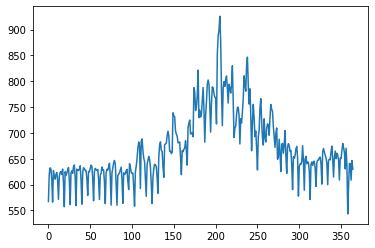

In [6]:
plt.plot(customer_consumption)

## Data selection

In [7]:
year_ini = 2023
year_end = 2028

vol_inf = 0
vol_sup = 999999

pricing = None

In [8]:
year_ini = 2023
year_end = 2028

vol_inf = 0
vol_sup = 999999

pricing = None

years_list = np.arange(year_ini,year_end + 1).tolist()

useful_cols = ['Company', 'Technology', 'Capacity (MW)', 'Annual output P50 - (MWh)', 'Volume - (MWh)', 'Pricing Methodology'] + years_list

data = data_RfP[useful_cols]

In [9]:
def data_selection(data_RfP, year_ini, year_end, vol_inf, vol_sup, pricing):
    
    years_list = np.arange(year_ini,year_end + 1).tolist()
    data = data_RfP[useful_cols]
    
    # VOLUME

    # Eliminate rows with no Pay As Produce (Volume)
    data = data.dropna(subset=['Volume - (MWh)'])
    # Select within volume range
    data = data[data['Volume - (MWh)'] >= vol_inf]
    data = data[data['Volume - (MWh)'] <= vol_sup]
    
    # PRICE

    # Eliminate rows with no offer within year range
    data = data.dropna(subset=years_list)
    # Select pricing method
    if pricing == 'Fixed':
        data = data[data['Pricing Method'] == 'Fixed']
    if pricing == 'Indexed':
        data = data[data['Pricing Method'] == 'Indexed']
    # Create total mean price for selected period
    data['Mean price'] = data[years_list].mean(axis=1)
    
    # Eliminate empty capacities or annual outputs
    data = data.dropna(subset=['Capacity (MW)'])
    data = data.dropna(subset=['Annual output P50 - (MWh)'])
    # Eliminate "TBA" rows
    data = data[data['Capacity (MW)']!="TBA"]
    data = data[data['Annual output P50 - (MWh)']!="TBA"]
    # Transform object types into numbers
    data['Capacity (MW)'] = data['Capacity (MW)'].astype(float)
    data['Annual output P50 - (MWh)'] = data['Annual output P50 - (MWh)'].astype(float)
    
    data['Technology'] = data['Technology'].str.lower()
    
    # Create unique asset indicator
    data['Unique asset indicator'] = data['Technology'] + ' ' + data['Company'] + ' ' + data['Annual output P50 - (MWh)'].astype(str)
    
    selected = pd.DataFrame()

    for asset in data['Unique asset indicator'].unique():
        one_asset = data[data['Unique asset indicator'] == asset]
        min_price = one_asset[one_asset['Mean price'] == one_asset['Mean price'].min()]
        selected = pd.concat([selected, min_price], axis = 0)
        
    data = selected.copy()
    data.reset_index(drop=True, inplace=True)
    
    return data

In [10]:
data = data_selection(data_RfP, year_ini, year_end, vol_inf, vol_sup, pricing)

In [11]:
data.head()

,Company,Technology,Capacity (MW),Annual output P50 - (MWh),Volume - (MWh),Pricing Methodology,2023,2024,2025,2026,2027,2028,Mean price,Unique asset indicator
0,BayWa r.e.,onshore wind,57.00,147000.0,147500.0,Indexed,51.097165,52.119109,53.161491,54.224720,55.309215,56.415399,53.721183,onshore wind BayWa r.e. 147000.0
1,Brookfield,onshore wind,20.00,69000.0,69000.0,Indexed,45.000000,47.900000,48.858000,49.835160,50.831863,51.848500,49.045587,onshore wind Brookfield 69000.0
2,EDF Renewables,solar,49.99,66380.0,66380.0,Indexed,42.330000,43.176600,44.040132,44.920935,45.819353,46.735740,44.503793,solar EDF Renewables 66380.0
3,EnregieKontor,onshore wind,36.00,135000.0,114750.0,Indexed,43.250000,44.115000,44.997300,45.897246,46.815191,47.751495,45.471039,onshore wind EnregieKontor 135000.0
4,EnregieKontor,onshore wind,12.60,40000.0,89000.0,Indexed,43.860000,44.737200,45.631944,46.544583,47.475475,48.424984,46.112364,onshore wind EnregieKontor 40000.0


# Generate estimated daily production

In [12]:
def estimated_daily_production(data, level):
    
    if level == 1:
        solar_shape = pd.read_csv('scaled_solar_shape.csv',index_col=0).values
        
        # Get daily averages & mean of the one day solar shape
        data["Gen_HHavg"] = data['Volume - (MWh)']/365/48
        solar_mean = solar_shape.mean()
        
        HH_prod_list = []

        for i in data.index:
            row = data.loc[i]#
            #print(row["Technology"])
            if row["Technology"] == 'onshore wind':
                #print("Is Onshore wind")
                HH_prod_list += [[row['Gen_HHavg']]*48]
            if row["Technology"] == 'solar (bt)':
                #print("Is Solar")
                HH_prod_list += [list(np.reshape(row['Gen_HHavg']*solar_shape,(1,-1))[0])]
            if row["Technology"] == 'solar':
                #print("Is Solar")
                HH_prod_list += [list(np.reshape(row['Gen_HHavg']*solar_shape,(1,-1))[0])]
                
        HH_prod = np.array(HH_prod_list)
        forecast_headers = ['HH ' + str(i+1) for i in range(0, HH_prod.shape[1])]
        HH_prod_df = pd.DataFrame(HH_prod, columns = forecast_headers)
        data = pd.concat([data, HH_prod_df], axis=1)
        
        return data, forecast_headers
    
    if level == 2:
        solar_shape = pd.read_csv('solar_shape_2.csv',index_col=0).values/1000
        wind_shape = pd.read_csv('wind_shape_2.csv',index_col=0).values/1000
        
        # Get daily averages & mean of the one day solar shape
        data["Gen_HHavg"] = data['Volume - (MWh)']/365
        solar_mean = solar_shape.mean()
        wind_mean = wind_shape.mean()
        
        P_50_wind_D = data[data['Company'] == 'EDF Renewables'][['Volume - (MWh)']].values[0][0]/365
        
        HH_prod_list = []

        for i in data.index:
            row = data.loc[i]#
            #print(row["Technology"])
            if row["Technology"] == 'onshore wind':
                #print("Is Onshore wind")
                HH_prod_list += [list((np.reshape((row['Gen_HHavg'] / wind_mean)*wind_shape, (1,-1))[0]))]
                #HH_prod_list += [[row['Gen_HHavg']]*48]
            if row["Technology"] == 'offshore wind':
                #print("Is Onshore wind")
                HH_prod_list += [list((np.reshape((row['Gen_HHavg'] / wind_mean)*wind_shape, (1,-1))[0]))]
            if row["Technology"] == 'solar (bt)':
                #print("Is Solar")
                HH_prod_list += [list(np.reshape((row['Gen_HHavg'] / solar_mean)*solar_shape,(1,-1))[0])]
            if row["Technology"] == 'solar':
                #print("Is Solar")
                HH_prod_list += [list(np.reshape((row['Gen_HHavg'] / solar_mean)*solar_shape,(1,-1))[0])]
            
        HH_prod = np.array(HH_prod_list)
        forecast_headers = ['Day ' + str(i+1) for i in range(0, HH_prod.shape[1])]
        HH_prod_df = pd.DataFrame(HH_prod, columns = forecast_headers)
        data = pd.concat([data, HH_prod_df], axis=1)
        
        return data, forecast_headers

In [13]:
data, forecast_headers = estimated_daily_production(data, level)

In [14]:
data.head()

,Company,Technology,Capacity (MW),Annual output P50 - (MWh),Volume - (MWh),Pricing Methodology,2023,2024,2025,2026,...,Day 356,Day 357,Day 358,Day 359,Day 360,Day 361,Day 362,Day 363,Day 364,Day 365
0,BayWa r.e.,onshore wind,57.00,147000.0,147500.0,Indexed,51.097165,52.119109,53.161491,54.224720,...,562.014353,553.296613,552.715906,555.772861,552.609352,552.966244,550.966289,549.682715,552.012997,552.163342
1,Brookfield,onshore wind,20.00,69000.0,69000.0,Indexed,45.000000,47.900000,48.858000,49.835160,...,262.908409,258.830280,258.558627,259.988660,258.508782,258.675734,257.740162,257.139711,258.229809,258.300140
2,EDF Renewables,solar,49.99,66380.0,66380.0,Indexed,42.330000,43.176600,44.040132,44.920935,...,44.243734,43.872900,44.676269,44.892998,45.864861,47.548620,47.027898,47.550710,47.408268,47.671562
3,EnregieKontor,onshore wind,36.00,135000.0,114750.0,Indexed,43.250000,44.115000,44.997300,45.897246,...,437.228115,430.446009,429.994239,432.372446,429.911343,430.188993,428.633096,427.634519,429.447400,429.564362
4,EnregieKontor,onshore wind,12.60,40000.0,89000.0,Indexed,43.860000,44.737200,45.631944,46.544583,...,339.113745,333.853550,333.503157,335.347692,333.438863,333.654208,332.447456,331.672960,333.079029,333.169745


# Optimisation

In [15]:
data

,Company,Technology,Capacity (MW),Annual output P50 - (MWh),Volume - (MWh),Pricing Methodology,2023,2024,2025,2026,...,Day 356,Day 357,Day 358,Day 359,Day 360,Day 361,Day 362,Day 363,Day 364,Day 365
0,BayWa r.e.,onshore wind,57.00,147000.0,147500.0,Indexed,51.097165,52.119109,53.161491,54.224720,...,562.014353,553.296613,552.715906,555.772861,552.609352,552.966244,550.966289,549.682715,552.012997,552.163342
1,Brookfield,onshore wind,20.00,69000.0,69000.0,Indexed,45.000000,47.900000,48.858000,49.835160,...,262.908409,258.830280,258.558627,259.988660,258.508782,258.675734,257.740162,257.139711,258.229809,258.300140
2,EDF Renewables,solar,49.99,66380.0,66380.0,Indexed,42.330000,43.176600,44.040132,44.920935,...,44.243734,43.872900,44.676269,44.892998,45.864861,47.548620,47.027898,47.550710,47.408268,47.671562
3,EnregieKontor,onshore wind,36.00,135000.0,114750.0,Indexed,43.250000,44.115000,44.997300,45.897246,...,437.228115,430.446009,429.994239,432.372446,429.911343,430.188993,428.633096,427.634519,429.447400,429.564362
4,EnregieKontor,onshore wind,12.60,40000.0,89000.0,Indexed,43.860000,44.737200,45.631944,46.544583,...,339.113745,333.853550,333.503157,335.347692,333.438863,333.654208,332.447456,331.672960,333.079029,333.169745
5,Foresight,onshore wind,49.00,140352.0,140352.0,Indexed,46.899600,47.819200,48.738800,49.658400,...,534.778566,526.483297,525.930731,528.839543,525.829341,526.168937,524.265902,523.044532,525.261886,525.404945
6,Foresight,solar,504.30,220000.0,220000.0,Indexed,53.019600,54.059200,55.098800,56.138400,...,146.634853,145.405814,148.068381,148.786678,152.007675,157.588076,155.862272,157.595002,157.122913,157.995534
7,Greencoat,onshore wind,45.00,131000.0,131000.0,Indexed,42.330000,43.160000,43.990000,44.820000,...,499.144951,491.402416,490.886669,493.601660,490.792035,491.109003,489.332772,488.192784,490.262391,490.395917
8,LSBP,solar,32.00,34408.0,34408.0,Fixed,48.000000,48.000000,48.000000,48.000000,...,22.933691,22.741469,23.157895,23.270236,23.774000,24.646775,24.376859,24.647858,24.574024,24.710502
9,LSBP,solar,46.00,51100.0,51100.0,Fixed,47.600000,47.600000,47.600000,47.600000,...,34.059277,33.773805,34.392247,34.559087,35.307237,36.603412,36.202555,36.605021,36.495368,36.698054


In [16]:
def add_prices_list(df, load):
    
    def rmse(x,y):
        return sqrt(mse(x,y))
    
    # Capture the shape of the cumulative generation
    cumulative_gen_load = np.zeros(len(forecast_headers))
    #print(len(cumulative_gen_load))
    errors_list = []
    prices_list = []
    # New added to capture the price every year
    price_yearly = []
    
    for i in range(0,df.shape[0]):
        #print(len(df.iloc[i][forecast_headers].values))
        cumulative_gen_load = cumulative_gen_load + df.iloc[i][forecast_headers].values
        errors_list += [rmse(cumulative_gen_load,load)]
        price_one = []
        for price in years_list:
            if level == 1:
                price_one += [((df.iloc[i][price] * df.iloc[i][forecast_headers])*365).values.sum()]
            if level == 2:
                price_one += [(df.iloc[i][price] * df.iloc[i][forecast_headers]).values.sum()]
            #print(price_one)
        prices_list += [np.array(price_one).sum()]
        price_yearly += [price_one]
        
    price_yearly_header = ['Asset price ' + str(year) for year in years_list]
    df = pd.concat([df, pd.DataFrame(errors_list,columns=['rmse'],index = df.index), pd.DataFrame(prices_list,columns=['cost'],index = df.index), pd.DataFrame(np.array(price_yearly), columns = price_yearly_header)], axis=1)
    
    return df, price_yearly_header

In [28]:
one_tech_based = None

def asset_optimise_plot(data, level, forecast_headers, baseload, one_tech_based):

    # Solar or wind only
    if one_tech_based == 'solar':
        data = data[data['Technology'].str.contains(one_tech_based)]

    if one_tech_based == 'wind':
        data = data[data['Technology'].str.contains(one_tech_based)]

    data = data.reset_index(drop=True)
    data_opt, price_yearly_header = add_prices_list(data, baseload)
    
    # Generation aggregated (Optimal)
    gen_optimal = data_opt.loc[0:data_opt['rmse'].idxmin()]
    # Generation aggregated (Limite inferior)
    gen_inf = data_opt.loc[0:data_opt['rmse'].idxmin() - 1]
    # Generation aggregated (Limite superior)
    gen_sup = data_opt.loc[0:data_opt['rmse'].idxmin() + 1]
    
    wind_technologies = ['onshore wind','offshore wind','wind']
    solar_technologies = ['solar', 'solar (bt)']
    
    # Suppress this warning in the future
    if gen_optimal[gen_optimal['Technology'].str.contains('wind')].shape[0] > 0:
        wind_gen_optimal = gen_optimal.set_index(['Technology']).loc[wind_technologies].dropna(subset=['Capacity (MW)']).reset_index()
        wind_gen_aggregated = wind_gen_optimal[forecast_headers].values.sum(axis=0)
    else:
        wind_gen_aggregated = 0
        
    if gen_optimal[gen_optimal['Technology'].str.contains('solar')].shape[0] > 0:
        solar_gen_optimal = gen_optimal.set_index(['Technology']).loc[solar_technologies].dropna(subset=['Capacity (MW)']).reset_index()
        solar_gen_aggregated = solar_gen_optimal[forecast_headers].values.sum(axis=0)
    else:
        solar_gen_aggregated = 0
    
    if gen_optimal[gen_optimal['Technology'].str.contains('wind')].shape[0] > 0:
        # Select wind only for baseload and solar only for peakload
        wind_technologies = ['onshore wind','offshore wind','wind']
        wind_df = data.set_index(['Technology']).loc[wind_technologies].dropna(subset=['Capacity (MW)']).reset_index()
        # Sort from min to max avg price
        wind_df_sorted_price = wind_df.sort_values(['Mean price']).reset_index(drop=True)
        # Add list with prices
        wind_df_final, price_yearly_header = add_prices_list(wind_df_sorted_price, baseload)
        # Generation aggregated (Optimal)
        wind_gen_optimal = wind_df_final.loc[0:wind_df_final['rmse'].idxmin()]
        wind_gen_aggregated = wind_gen_optimal[forecast_headers].values.sum(axis=0)
        # Generation aggregated (Limite inferior)
        wind_gen_inf = wind_df_final.loc[0:wind_df_final['rmse'].idxmin() - 1]
        # Generation aggregated (Limite superior)
        wind_gen_sup = wind_df_final.loc[0:wind_df_final['rmse'].idxmin() + 1]
    else:
        wind_gen_aggregated = np.zeros(len(forecast_headers))

    # Get peaklaod from aggregated wind generation IF there are wind rows
    if gen_optimal[gen_optimal['Technology'].str.contains('wind')].shape[0] > 0:
        peakload = customer_consumption - wind_gen_aggregated
    else:
        peakload = customer_consumption

    if gen_optimal[gen_optimal['Technology'].str.contains('solar')].shape[0] > 0:
        # Select wind only for baseload and solar only for peakload
        solar_technologies = ['solar', 'solar (bt)']
        solar_df = data.set_index(['Technology']).loc[solar_technologies].dropna(subset=['Capacity (MW)']).reset_index()
        # Sort from min to max avg price
        solar_df_sorted_price = solar_df.sort_values(['Mean price']).reset_index(drop=True)
        # Add list with prices
        solar_df_final, price_yearly_header = add_prices_list(solar_df_sorted_price, peakload)
        # Generation aggregated (Optimal)
        solar_gen_optimal = solar_df_final.loc[0:solar_df_final['rmse'].idxmin()]
        solar_gen_aggregated = solar_gen_optimal[forecast_headers].values.sum(axis=0)
        # Generation aggregated (Limite inferior)
        solar_gen_inf = solar_df_final.loc[0:solar_df_final['rmse'].idxmin() - 1]
        # Generation aggregated (Limite superior)
        solar_gen_sup = solar_df_final.loc[0:solar_df_final['rmse'].idxmin() + 1]
    else:
        solar_gen_aggregated = np.zeros(len(forecast_headers))
        
    fig = go.Figure()

    if gen_optimal[gen_optimal['Technology'].str.contains('wind')].shape[0] > 0:

        fig.add_trace(go.Scatter(
                        x=forecast_headers,
                        y=wind_gen_aggregated,
                        name="Wind",
                        opacity=0.8))

    if gen_optimal[gen_optimal['Technology'].str.contains('solar')].shape[0] > 0:

        fig.add_trace(go.Scatter(
                        x=forecast_headers,
                        y=solar_gen_aggregated,
                        name="Solar",
                        opacity=0.8))

    fig.add_trace(go.Scatter(
                    x=forecast_headers,
                    y=customer_consumption,
                    name="Iceland consumption",
                    opacity=0.8))

    fig.update_layout(title_text="(LvL. " + str(level) + ") Generation vs consumption profile match",
                     yaxis_title="MWh")
    fig.show()
    
    # PRINT REPORT FROM HERE
    
    if gen_optimal[gen_optimal['Technology'].str.contains('wind')].shape[0] == 0:
        wind_price_yearly_total = 0
        n_wind = 0
    else:
        wind_price_yearly_total = wind_gen_optimal[price_yearly_header].sum(axis=0).values
        n_wind = wind_gen_optimal.shape[0]
        
    if gen_optimal[gen_optimal['Technology'].str.contains('solar')].shape[0] == 0:
        solar_price_yearly_total = 0
        n_solar = 0
    else:
        solar_price_yearly_total = solar_gen_optimal[price_yearly_header].sum(axis=0).values
        n_solar = solar_gen_optimal.shape[0]
        
    total_price_yearly = wind_price_yearly_total + solar_price_yearly_total
    
    deviation = 0.1

    price_inf = total_price_yearly.sum()*(1-deviation)
    price_sup = total_price_yearly.sum()*(1+deviation)
    
    if level == 1:
        base = baseload.sum()
    if level == 2:
        base = baseload[0]

    if level == 1:
        peak = peakload.sum()
    if level == 2:
        peak = peakload.mean()
        
    gen_aggregated = wind_gen_aggregated.sum() + solar_gen_aggregated.sum()
    
    ##################################################################################################
    
    if pricing == None:
        price_method = "All"
    else:
        price_method = pricing

    print()
    print('CONSUMPTION SUMMARY (MWh)')
    print()
    print('Estimated baseload (daily): ' + str(round(base,2)))
    print('Estimated mean peakload (daily): ' + str(round(peak,2)))
    print()
    print('Estimated baseload (yearly): ' + str(round(base*365,2)))
    print('Estimated mean peakload (yearly): ' + str(round(peak,2)*365))
    print()
    #print('Total Estimated (yearly total): ' + str(round(base*365 + round(peak,2)*365,2)))
    #print()
    print('--------------------------------------------------------')
    print('PRICE SUMMARY')
    print()
    if gen_optimal[gen_optimal['Technology'].str.contains('wind')].shape[0] > 0:
        print('Mean cost of Wind: ' + str(round(wind_gen_optimal['Mean price'].mean(),2)) + '£/MWh')
    if gen_optimal[gen_optimal['Technology'].str.contains('solar')].shape[0] > 0:
        print('Mean cost of Solar: ' + str(round(solar_gen_optimal['Mean price'].mean(),2)) + '£/MWh')
    print()
    print('Estimate Yearly value of the contract:')
    [print(str(year), end ="   ") for year in years_list]
    print()
    [print("£" + str(int(price/1000000)) + 'M', end ="   ") for price in total_price_yearly]
    print()
    print()
    print("Total Estimate Contract Value between " + str(years_list[0]) + " and " + str(years_list[-1]) + ":")
    print("£" + str(int(price_inf/1000000)) + "M and " + "£" + str(int(price_sup/1000000)) + "M")
    print()
    if gen_optimal[gen_optimal['Technology'].str.contains('wind')].shape[0] == 0:
        print("Estimate wind cost: " + str(0) + 'M')
    else:
        print("Estimate wind cost: " + str(int(wind_price_yearly_total.sum()/1000000)) + "M")
    if gen_optimal[gen_optimal['Technology'].str.contains('solar')].shape[0] == 0:
        print("Estimate solar cost: " + str(0) + 'M')
    else:
        print("Estimate Solar cost: " + str(int(solar_price_yearly_total.sum()/1000000)) + "M")
    print()
    print('--------------------------------------------------------')
    #print("Recommended approximation: " + str(round(n_solar*100/(n_solar + n_wind))) + "% Solar and " + str(round(n_wind*100/(n_solar + n_wind))) + "% Wind")
    print("Recommended approximation: " + str(round(solar_gen_aggregated.sum()*100/(gen_aggregated))) + "% Solar and " + str(round(wind_gen_aggregated.sum()*100/(gen_aggregated))) + "% Wind")
    print()
    print("Total load: " + str(round(customer_consumption.sum())))
    print("Approx. combined Solar & Wind generation: " + str(round(gen_aggregated)))
    print()
    print("Number of Solar generators: " + str(n_solar))
    print("Number of Wind generators: " + str(n_wind))
    print()
    print("Pricing method: " + price_method)
    print()
    
    if gen_optimal[gen_optimal['Technology'].str.contains('wind')].shape[0] > 0:
        frac_wind = wind_df.shape[0]/wind_gen_optimal.shape[0]
        if frac_wind == 1:
            print("All WIND assets used")
            
    if gen_optimal[gen_optimal['Technology'].str.contains('solar')].shape[0] > 0:
        frac_solar = solar_df.shape[0]/solar_gen_optimal.shape[0]
        if frac_solar == 1:
            print("All SOLAR assets used")
            print()

In [29]:
asset_optimise_plot(data, level, forecast_headers, baseload, one_tech_based)

C:\Users\jose_\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike

C:\Users\jose_\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike




CONSUMPTION SUMMARY (MWh)

Estimated baseload (daily): 604.38
Estimated mean peakload (daily): -3.73

Estimated baseload (yearly): 220598.15
Estimated mean peakload (yearly): -1361.45

--------------------------------------------------------
PRICE SUMMARY

Mean cost of Wind: 44.94£/MWh

Estimate Yearly value of the contract:
2023   2024   2025   2026   2027   2028   
£10M   £10M   £10M   £11M   £11M   £11M   

Total Estimate Contract Value between 2023 and 2028:
£59M and £72M

Estimate wind cost: 66M
Estimate solar cost: 0M

--------------------------------------------------------
Recommended approximation: 0.0% Solar and 100.0% Wind

Total load: 244390.0
Approx. combined Solar & Wind generation: 245750.0

Number of Solar generators: 0
Number of Wind generators: 2

Pricing method: All

